# 0. GPU 사용환경 구축 확인

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


from tensorflow.python.client import device_lib
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
print(device_lib.list_local_devices())
print('GPU Avaliable: ', tf.test.is_gpu_available())

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13430862081959723292
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 13418364928
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18105256005769713248
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Avaliable:  True


In [2]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.6.0
1.21.4


# 1. 데이터 불러오기 & resize

In [3]:
from PIL import Image
import glob
import os
print('PIL 라이브러리 import 완료')

PIL 라이브러리 import 완료


In [4]:
def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")  
    
	print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
	target_size=(28,28)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
    
	print(len(images), " images resized.")

In [5]:
# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path_scissor = os.getenv("HOME") + "/aiffel/0305_rcp/scissor/scissor"
resize_images(image_dir_path_scissor)

print("가위 이미지 resize 완료!")

2204  images to be resized.
2204  images resized.
가위 이미지 resize 완료!


In [6]:
image_dir_path_rock = os.getenv("HOME") + '/aiffel/0305_rcp/rock/rock'
resize_images(image_dir_path_rock)
print('바위 Resized')

1967  images to be resized.
1967  images resized.
바위 Resized


In [7]:
image_dir_path_paper = os.getenv("HOME") + '/aiffel/0305_rcp/paper/paper'
resize_images(image_dir_path_paper)
print('보 Resized')

1876  images to be resized.
1876  images resized.
보 Resized


In [8]:
import numpy as np

def load_data(img_path, number_of_data=6047):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

# 2. 데이터 전처리

In [9]:
image_dir_path = os.getenv("HOME") + "/aiffel/0305_rcp"
(x_train, y_train)=load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 6047 입니다.
x_train shape: (6047, 28, 28, 3)
y_train shape: (6047,)


라벨:  0


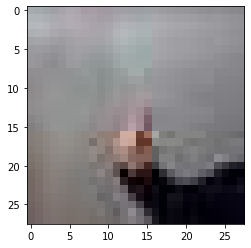

In [10]:
import matplotlib.pyplot as plt

a=2000
plt.imshow(x_train[a])
print('라벨: ', y_train[a])

# 3. 딥러닝 네트워크 설계

In [11]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

# model을 직접 만들어 보세요.
# Hint! model의 입력/출력부에 특히 유의해 주세요. 가위바위보 데이터셋은 MNIST 데이터셋과 어떤 점이 달라졌나요?

# 아래의 하이퍼파라미터는 예시입니다. 높은 인식률을 얻기 위해 하이퍼파라미터를 수정해 보세요. 
n_channel_1=32
n_channel_2=64
n_dense_1=64
n_dense_2=32
n_train_epoch=10

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense_1, activation='relu'))
model.add(keras.layers.Dense(n_dense_2, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                102464    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2

# 4. 딥러닝 네트워크 학습

In [12]:
model.compile(optimizer ='adam',
             loss= 'sparse_categorical_crossentropy',
             metrics= ['accuracy'])

model.fit(x_train, y_train, epochs=12)

Epoch 1/12
189/189 [==============================] - 3s 3ms/step - loss: 1.1086 - accuracy: 0.6927
Epoch 2/12
189/189 [==============================] - 1s 3ms/step - loss: 0.1970 - accuracy: 0.9291
Epoch 3/12
189/189 [==============================] - 1s 3ms/step - loss: 0.0851 - accuracy: 0.9732
Epoch 4/12
189/189 [==============================] - 1s 3ms/step - loss: 0.0558 - accuracy: 0.9836
Epoch 5/12
189/189 [==============================] - 1s 3ms/step - loss: 0.0279 - accuracy: 0.9939
Epoch 6/12
189/189 [==============================] - 1s 3ms/step - loss: 0.0103 - accuracy: 0.9988
Epoch 7/12
189/189 [==============================] - 1s 3ms/step - loss: 0.0679 - accuracy: 0.9755
Epoch 8/12
189/189 [==============================] - 1s 3ms/step - loss: 0.0287 - accuracy: 0.9911
Epoch 9/12
189/189 [==============================] - 1s 3ms/step - loss: 0.0566 - accuracy: 0.9802
Epoch 10/12
189/189 [==============================] - 1s 3ms/step - loss: 0.0339 - accuracy: 0.9893

>  Sparse_categorical_crossentropy : y를 1-10까지의 범주형으로 나눈다 & sparse의 의미는 1-10 중 오직 하나만 고를 수 있다는 것.

# 5. 테스트

In [13]:
import numpy as np

def load_data(img_path, number_of_data=300):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("테스트데이터(x_test)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/0305_rcp/test"
(x_train, y_train)=load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

테스트데이터(x_test)의 이미지 개수는 300 입니다.


In [14]:
image_dir_path = os.getenv("HOME") + "/aiffel/0305_rcp/test/scissor"
resize_images(image_dir_path)

image_dir_path = os.getenv("HOME") + "/aiffel/0305_rcp/test/rock"
resize_images(image_dir_path)

image_dir_path = os.getenv("HOME") + "/aiffel/0305_rcp/test/paper"
resize_images(image_dir_path)

image_dir_path = os.getenv("HOME") + "/aiffel/0305_rcp/test"
(x_test, y_test)=load_data(image_dir_path)
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화
print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))


100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
테스트데이터(x_test)의 이미지 개수는 300 입니다.
x_test shape: (300, 28, 28, 3)
y_test shape: (300,)


In [15]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

10/10 - 0s - loss: 0.0016 - accuracy: 1.0000
test_loss: 0.0016226398292928934 
test_accuracy: 1.0


In [16]:
predicted_result = model.predict(x_test)  # model이 추론한 확률값. 
predicted_labels = np.argmax(predicted_result, axis=1) #확률값이 최대인 것

idx=0  #1번째 x_test를 살펴보자. 
print('model.predict() 결과 : ', predicted_result[idx])
print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx])
print('실제 데이터의 라벨 : ', y_test[idx])

model.predict() 결과 :  [1.0000000e+00 7.1321199e-20 9.2855905e-12]
model이 추론한 가장 가능성이 높은 결과 :  0
실제 데이터의 라벨 :  0


In [17]:
import random

wrong_predict_list = []

for i, _ in enumerate(predicted_labels):
    # i번째 test_labels과 y_test이 다른 경우만 모아 봅시다. 
    if predicted_labels[i] != y_test[i]:
        wrong_predict_list.append(i)

# Check if wrong_predict_list is not empty
if wrong_predict_list:
    # wrong_predict_list에서 랜덤하게 5개만 뽑아봅시다.
    samples = random.choices(population=wrong_predict_list, k=min(5, len(wrong_predict_list)))

    for n in samples:
        print("예측확률분포: " + str(predicted_result[n]))
        print("라벨: " + str(y_test[n]) + ", 예측결과: " + str(predicted_labels[n]))
        plt.imshow(x_test[n], cmap=plt.cm.binary)
        plt.show()
else:
    print("No wrong predictions found.")

No wrong predictions found.


# 다른 테스트 데이터 

In [18]:
image_dir_path = os.getenv("HOME") + "/aiffel/0305_rcp/test2/scissor"
resize_images(image_dir_path)

image_dir_path = os.getenv("HOME") + "/aiffel/0305_rcp/test2/rock"
resize_images(image_dir_path)

image_dir_path = os.getenv("HOME") + "/aiffel/0305_rcp/test2/paper"
resize_images(image_dir_path)

image_dir_path = os.getenv("HOME") + "/aiffel/0305_rcp/test2"
(x_test, y_test)=load_data(image_dir_path, number_of_data=1133)
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화
print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

392  images to be resized.
392  images resized.
365  images to be resized.
365  images resized.
376  images to be resized.
376  images resized.
테스트데이터(x_test)의 이미지 개수는 1133 입니다.
x_test shape: (1133, 28, 28, 3)
y_test shape: (1133,)


In [19]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

36/36 - 0s - loss: 3.5389 - accuracy: 0.5402
test_loss: 3.5389275550842285 
test_accuracy: 0.5401588678359985


예측확률분포: [1.0668219e-26 1.0000000e+00 9.3408040e-26]
라벨: 0, 예측결과: 1


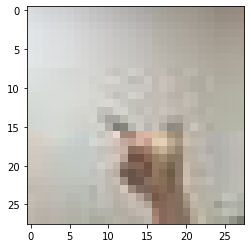

예측확률분포: [1.1743819e-11 1.0000000e+00 1.2460322e-09]
라벨: 0, 예측결과: 1


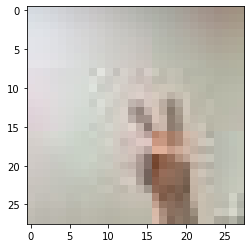

예측확률분포: [2.773958e-11 3.166635e-12 1.000000e+00]
라벨: 0, 예측결과: 2


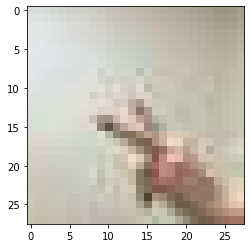

예측확률분포: [9.2227022e-23 1.0000000e+00 1.3879156e-18]
라벨: 0, 예측결과: 1


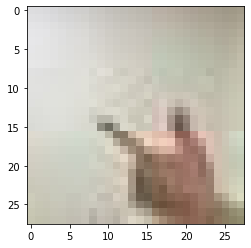

예측확률분포: [4.173803e-11 9.999906e-01 9.469331e-06]
라벨: 0, 예측결과: 1


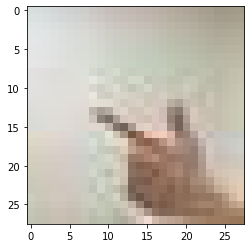

In [20]:
import random
wrong_predict_list=[]
for i, _ in enumerate(predicted_labels):
    # i번째 test_labels과 y_test이 다른 경우만 모아 봅시다. 
    if predicted_labels[i] != y_test[i]:
        wrong_predict_list.append(i)

# wrong_predict_list 에서 랜덤하게 5개만 뽑아봅시다.
samples = random.choices(population=wrong_predict_list, k=5)

for n in samples:
    print("예측확률분포: " + str(predicted_result[n]))
    print("라벨: " + str(y_test[n]) + ", 예측결과: " + str(predicted_labels[n]))
    plt.imshow(x_test[n], cmap=plt.cm.binary)
    plt.show()

# 💡 회고

### 과정
- 이 집 저 집에서 찍은(?) 사진들을 다 끌어모아서 6000개가 넘는 데이터로 훈련을 시켰고, 테스트 데이터 안에 훈련데이터가 겹치는 경우 당연하게 정확도는 높게 나온다. 반면, 훈련데이터가 300개만 있었을 때나, 훈련데이터와는 겹치지 않는 딴판의 test 데이터로 다시 확인을 해보니 성능이 50% 정도로 나온다. 이 수치도, epoch수를 5~10으로 조절 및 Dense layer을 하나 추가, 각 layer에 사용되는 뉴런의 숫자 (Conv2D에서는 이미지 특징의 수, Dense에서는 분류기에 사용되는 뉴런의 숫자) 를 조절할 경우 적게는 35%대에서 50%대까지 성능이 향상된 것을 볼 수 있다. 
- 처음에 test 데이터에다가 labeling 하는 것을 깜빡해서 성능이 저조하게 나왔다. 당연히 인덱스가 붙어있어야 예측을 하든 말든 할텐데 실수였다.

### 느낀 점
- 그런데 이거 상당히 재미있다. 일단 이미지가 들어가다보니, 코드만 짜다가 이미지를 예측할 수 있다는 점에 되게 매력을 느꼈고, 실질적으로 자율주행 자동차나 기타 여러가지 분아에 활발하게 쓰이고 있는 기술이라서 재미있었다. 역시 데이터가 많아질수록 모델 성능이 좋아질 수 밖에 없고, 과적합되지 않도록 파라미터 세밀하게 조정하는 걸 잘 봐야겠다.
- 딥러닝 더 열심히 배워야겠다.